In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from IPython.display import display
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['agg.path.chunksize'] = 10000

data = pd.read_csv('./df_input.csv', sep=';')

day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado",
}

# Reading Data file (geolocalized)
data = pd.read_csv('./df_input.csv', sep=';', delimiter=';')

# filtering by busline
busline_filter = 41
data_model = data.loc[data['linha'] == busline_filter]

#one hot enconding days of week
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_model_data = data_model.copy()
encoded_model_data[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model = encoded_model_data.copy()
display(data_model)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado
2418,41,2020-03-01 04:00:00,25,6,8.878852e-01,0.460065,4,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2419,41,2020-03-01 05:00:00,168,6,9.790841e-01,0.203456,5,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2420,41,2020-03-01 06:00:00,310,6,9.976688e-01,-0.068242,6,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2421,41,2020-03-01 07:00:00,339,6,9.422609e-01,-0.334880,7,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2422,41,2020-03-01 08:00:00,286,6,8.169699e-01,-0.576680,8,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,41,2020-12-31 20:00:00,138,3,-7.308360e-01,0.682553,20,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1418149,41,2020-12-31 21:00:00,83,3,-5.195840e-01,0.854419,21,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1418150,41,2020-12-31 22:00:00,54,3,-2.697968e-01,0.962917,22,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1418151,41,2020-12-31 23:00:00,30,3,-2.449294e-16,1.000000,23,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [2]:
time_steps = 24  #TAMANHO DA JANELA
test_size = 72  #HORIZONTE DE PREVISÃO
train_size = int(len(data_model)-(test_size))
train, test = data_model.iloc[0:train_size], data_model.iloc[(train_size-time_steps):len(data_model)]

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        #v = np.append(v,X.iloc[i + time_steps,0])#linha
        #v = np.append(v,X.iloc[i + time_steps,3])#d_semana
        #v = np.append(v,X.iloc[i + time_steps,2])#d_semana
        v = np.append(v,X.iloc[i + time_steps,4])#hr_sin
        v = np.append(v,X.iloc[i + time_steps,5])#hr_cos
        v = np.append(v,X.iloc[i + time_steps,7])#d_mes
        v = np.append(v,X.iloc[i + time_steps,8])#d_ano
        v = np.append(v,X.iloc[i + time_steps,9])#semana_do_mes
        v = np.append(v,X.iloc[i + time_steps,10])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,11])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,12])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,13])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,14])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,15])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,16])#d_semanaonehotencoded 
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['validations_per_hour'], time_steps)
X_test, y_test = create_dataset(test, test['validations_per_hour'], time_steps)


72
    real  predito
0    771   825.11
1    993  1010.96
2    751   657.79
3    355   414.59
4    168   190.56
..   ...      ...
67   138   190.82
68    83   166.51
69    54   218.78
70    30   126.74
71     2    27.90

[72 rows x 2 columns]
r2= 0.7621832395345165
rmse= 129.58416598875033
mae= 75.13499999999999
mape= 0.476009174519796


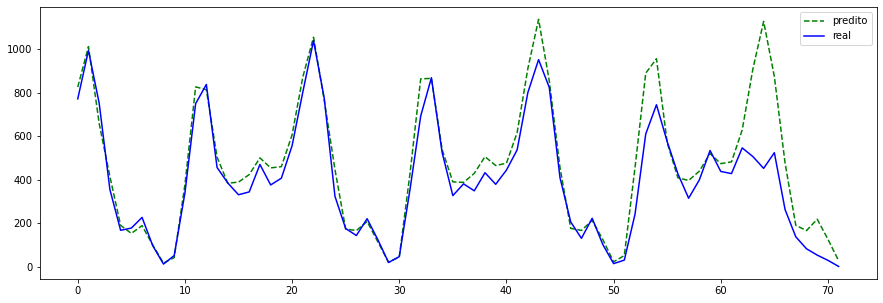

In [3]:
model = RandomForestRegressor(n_jobs=10).fit(X_train,y_train)
#model = LinearRegression().fit(X_train, y_train)
preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    y_pred = model.predict(np.array([base_teste[i]]))[0]

    preds.append(y_pred)
    
    for k in range(len(preds)):
        
        if i<len(base_teste):
            if k < time_steps:
                if(i<len(base_teste)-1):
                    base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]

print(len(preds))

dados_real = data_model.iloc[(train_size):len(data_model),2].to_numpy()

len(dados_real)

df_real_predito = pd.DataFrame({'real':dados_real,'predito':preds})

print(df_real_predito)
# X_train[0]

plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--', label='predito')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b', label='real')
plt.legend()
# plt.xlim(0,30)
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('mape=',mean_absolute_percentage_error(df_real_predito['real'].array,df_real_predito['predito'].array))

plt.show()